In [91]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')

In [92]:
train=pd.read_csv("merged_train.csv")
test=pd.read_csv("merged_test.csv")

In [93]:
# merged_ data에서 drop해야 할 단지코드
print(train.shape, test.shape)
train = train.loc[~train.단지코드.isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']),]
test = test.loc[~test.단지코드.isin(['C2335', 'C1327', 'C2675'])]
print(train.shape, test.shape)

(2896, 34) (1008, 33)
(2896, 34) (1008, 33)


In [94]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [95]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [96]:
print(train.shape, test.shape)

(2577, 34) (936, 33)


## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수, 분양세대수

In [97]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# 분양세대수 column 추가
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train = pd.merge(train, train_sale,on="단지코드")

test_sale = pd.DataFrame(test.groupby(['단지코드']).first()['총세대수'] - test.groupby(['단지코드']).sum()['전용면적별세대수'])
test_sale.columns = ["분양세대수"]
test_sale = test_sale.astype('int16')
test_sale.reset_index(inplace=True)
test = pd.merge(test, test_sale,on="단지코드")

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 39) (936, 38)


# 자격유형

In [98]:
##train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
#train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
#test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
#test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

# 공급유형

In [99]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [100]:
train.shape, test.shape

((2577, 38), (936, 37))

# 1차원 병합

In [101]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '분양세대수'],
      dtype='object')

In [102]:
len(set(train.단지코드))

414

In [103]:
data = train.drop(columns=['공급유형','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [104]:
data.shape

(414, 31)

In [105]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).nunique()['전용면적별세대수']).reset_index()

In [106]:
sample=sample[~sample.duplicated("단지코드")]

In [107]:
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1000,국민임대,6
1,C1004,영구임대,2
3,C1005,국민임대,3
4,C1013,국민임대,5
5,C1014,국민임대,7


In [108]:
sample= sample.drop(["전용면적별세대수"], axis=1)

In [109]:
data= pd.merge(data, sample, on="단지코드")

In [110]:
train_a=train[train.임대건물구분=="아파트"]

In [111]:
sample = train_a.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,104695.000000,4.705000e+06
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [112]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [113]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [114]:
data=pd.merge(data, sample, on="단지코드", how="inner")

In [115]:
sample1=pd.DataFrame(train.groupby("단지코드")["전용면적"].mean()).reset_index()
#sample2=pd.DataFrame(train.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
data=pd.merge(data, sample1, on="단지코드", how="inner")
#data=pd.merge(data, sample2, on="단지코드", how="inner")
data.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,...,70세이상_비율,상가비율,세대당_가능주차면수,공가수비율,분양세대수,공급유형,임대료,임대보증금,대형전용면적,전용면적
0,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,...,0.097223,0.0,1.144954,0.031193,0,국민임대,139557.142857,1.678714e+07,0,44.345714
1,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,도안 휴먼시아 4단지,대전광역시 유성구 상대로 40,...,0.052683,0.0,1.056743,0.010691,302,국민임대,165956.250000,2.598438e+07,0,39.326250
2,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,...,0.079323,0.0,0.972185,0.007947,120,국민임대,200914.000000,2.406060e+07,0,52.668000
3,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0,장신휴먼시아1단지,전라북도 익산시 오산면 선화로4길 66,...,0.187074,0.0,0.926724,0.020115,0,국민임대,120150.000000,1.772275e+07,0,42.982500
4,C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0,장신휴먼시아2단지,전라북도 익산시 오산면 선화로4길 24-9,...,0.187074,0.0,0.913428,0.015901,0,국민임대,119148.333333,1.742233e+07,0,42.575000


In [116]:
#sample1=pd.DataFrame(train.groupby("단지코드")["임대료"].std()).reset_index()
##sample2=pd.DataFrame(train.groupby("단지코드")["임대보증금"].std()).reset_index()
#data=pd.merge(data, sample1, on="단지코드", how="inner")
#data=pd.merge(data, sample2, on="단지코드", how="inner")
#data.head()

In [117]:
#sample1=pd.DataFrame(train.groupby("단지코드")["전용면적"].std()).reset_index()
#sample2=pd.DataFrame(train.groupby("단지코드")["전용면적별세대수"].std()).reset_index()
#data=pd.merge(data, sample1, on="단지코드", how="inner")
#data=pd.merge(data, sample2, on="단지코드", how="inner")
#data.head(3)

# Test에 똑같이

In [118]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 30)

In [119]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).nunique()['전용면적별세대수']).reset_index()
sample=sample[~sample.duplicated("단지코드")]
sample.head()
sample= sample.drop(["전용면적별세대수"], axis=1)
dat= pd.merge(dat, sample, on="단지코드")

In [120]:
test_a=test[test.임대건물구분=="아파트"]

In [121]:
sample = test_a.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,115875.000000,2.265000e+07
1,C1006,95811.666667,6.932500e+06
2,C1016,228010.000000,2.402675e+07
3,C1019,126430.000000,1.485750e+07
4,C1030,214216.666667,5.141333e+07


In [122]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [123]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [124]:
dat=pd.merge(dat, sample, on="단지코드", how="inner")

In [125]:
sample1=pd.DataFrame(test.groupby("단지코드")["전용면적"].mean()).reset_index()
#sample2=pd.DataFrame(test.groupby("단지코드")["전용면적별세대수"].mean()).reset_index()
dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat=pd.merge(dat, sample2, on="단지코드", how="inner")

#sample1=pd.DataFrame(test.groupby("단지코드")["임대료"].std()).reset_index()
#sample2=pd.DataFrame(test.groupby("단지코드")["임대보증금"].std()).reset_index()
#dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat=pd.merge(dat, sample2, on="단지코드", how="inner")

#sample1=pd.DataFrame(test.groupby("단지코드")["전용면적"].std()).reset_index()
#sample2=pd.DataFrame(test.groupby("단지코드")["전용면적별세대수"].std()).reset_index()
#dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat=pd.merge(dat, sample2, on="단지코드", how="inner")
dat.head()

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,단지명,도로명주소,연면적,...,70세이상_비율,상가비율,세대당_가능주차면수,공가수비율,분양세대수,공급유형,임대료,임대보증금,대형전용면적,전용면적
0,C1072,754,경기도,14,0.0,2,683,광명역세권 휴먼시아2단지,경기도 광명시 서원로 25,13.320,...,0.071040,0.0,0.905836,0.018568,0,국민임대,265843.750000,38120250.0,0,48.436250
1,C1128,1354,경기도,9,0.0,3,1216,광명역세권 휴먼시아1단지,경기도 광명시 성채안로 26,3773.770,...,0.071040,0.0,0.898080,0.006647,0,국민임대,245516.666667,34125000.0,0,46.178889
2,C1456,619,부산광역시,18,0.0,16,547,안락휴먼시아,부산광역시 동래구 충렬대로447번길 38,6035.780,...,0.127272,0.0,0.883683,0.029079,86,국민임대,222290.000000,33704875.0,0,44.771250
3,C1840,593,전라북도,7,0.0,3,543,장신휴먼시아3단지,전라북도 익산시 오산면 선화로4길 14,6006.870,...,0.187074,0.0,0.915683,0.011804,0,국민임대,123150.000000,18924250.0,0,44.492500
4,C1332,1297,경기도,11,0.0,2,1112,봇들마을 6단지,경기도 성남시 분당구 동판교로 212,361.789,...,0.071614,0.0,0.857363,0.008481,0,국민임대,292880.000000,41334500.0,0,46.453750


In [126]:
set(data.columns)-set(dat.columns)

{'등록차량수'}

# Correlation 확인

In [130]:
X_cor = data.select_dtypes(include="number")

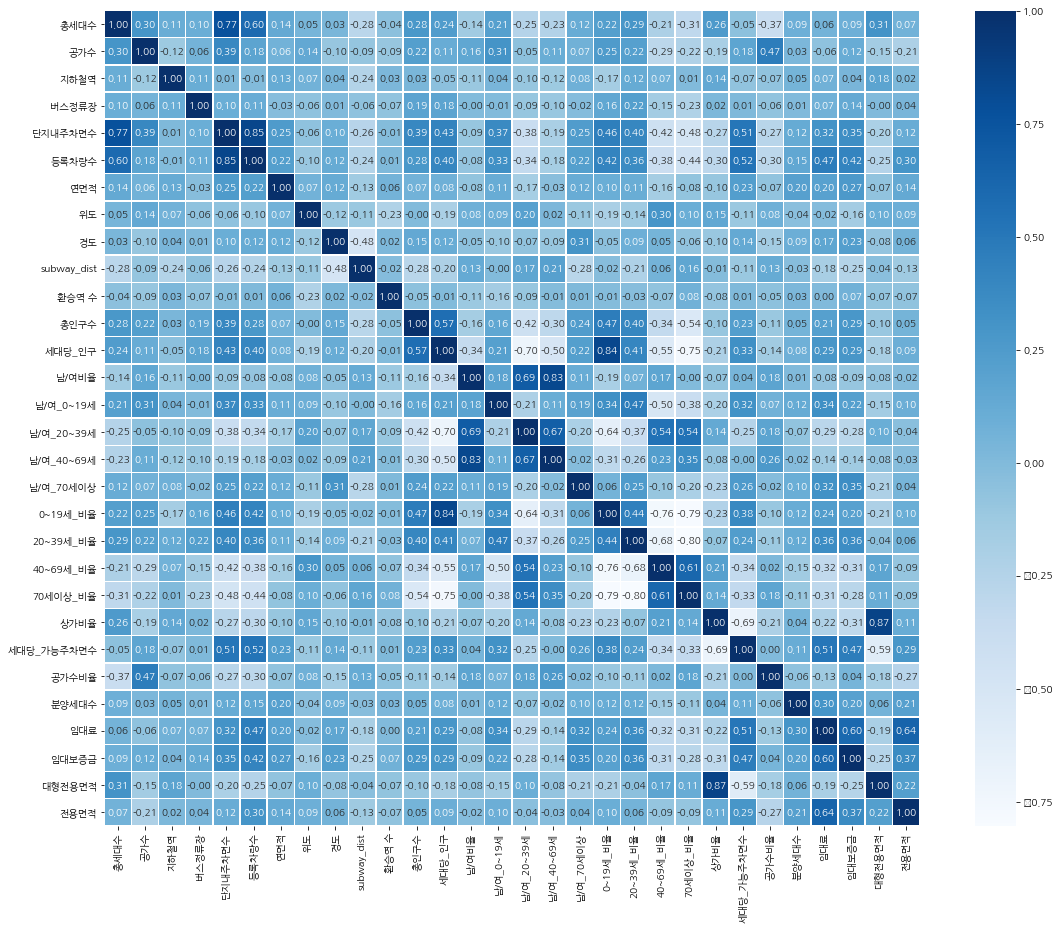

In [131]:
plt.subplots(figsize=(20,15))
sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

# Modeling

In [132]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

## 기본으로 돌려보기

In [143]:
X = data.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
y = data[['등록차량수']]

In [134]:
#X = pd.get_dummies(X, drop_first=True)

In [144]:
len(X.columns)

31

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [146]:
cb = CatBoostRegressor(cat_features=["지역", "공급유형"],
                       random_state=2021, verbose=False, 
                       loss_function="MAE").fit(X_train, y_train)
cb_pred = cb.predict(X_test)
mean_absolute_error(y_test, cb_pred)

121.23541504221302

Text(0.5, 0, 'CatBoost Feature Importance')

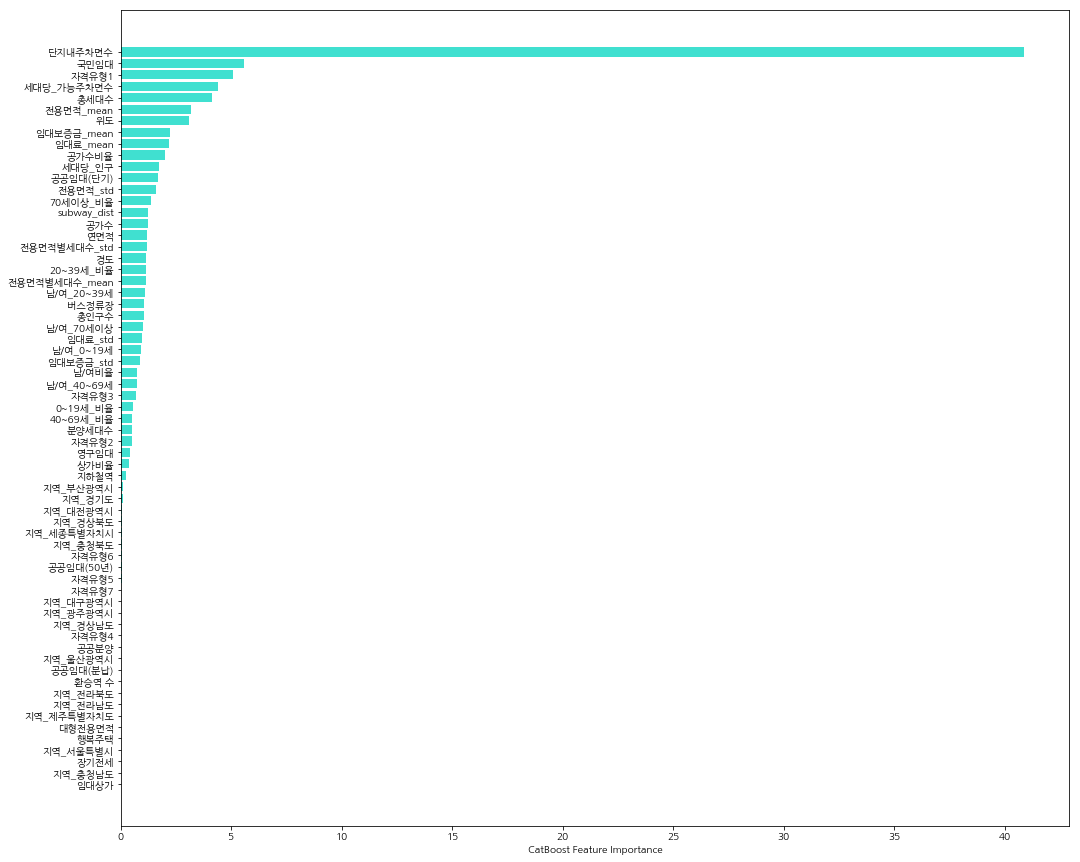

In [123]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = cb.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance], 
        cb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

## 나눠서 modeling

In [147]:
pd.concat([pd.DataFrame(data.단지내주차면수.describe()), pd.DataFrame(dat.단지내주차면수.describe())], axis=1)

,단지내주차면수,단지내주차면수
count,414.000000,147.000000
mean,586.330918,558.387755
std,363.665625,321.009953
min,13.000000,29.000000
25%,318.250000,313.000000
50%,517.000000,499.000000
75%,785.750000,726.000000
max,1798.000000,1696.000000


In [150]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [151]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 36) (104, 36)
(113, 35) (34, 35)


In [157]:
X = train2.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
y = train2[['등록차량수']]
#X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [110]:
#standardScaler.fit(X_train)
#X_train = standardScaler.transform(X_train)
#standardScaler.fit(X_test)
#X_test = standardScaler.transform(X_test)

In [158]:
cb = CatBoostRegressor(cat_features=["지역", "공급유형"],
                       random_state=2021, verbose=False, 
                       loss_function="MAE").fit(X_train, y_train)
cb_pred = cb.predict(X_test)
mean_absolute_error(y_test, cb_pred)

285.11477610536383

# 나눠서 예측

In [159]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [160]:
# sample = sample.loc[~sample.code.isin(['C2335', 'C1327', 'C2675'])]

In [161]:
sample.shape

(150, 2)

In [162]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [163]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 36) (104, 36)
(113, 35) (34, 35)


In [164]:
df= pd.concat([train1, test1])

In [166]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
#X = pd.get_dummies(X, drop_first=True)

In [167]:
X_train=X.iloc[0:310, :]
X_test=X.iloc[310:, :]
y_train = train1[['등록차량수']]

In [168]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [171]:
model_1=CatBoostRegressor(cat_features=["지역", "공급유형"],
                       random_state=2021, verbose=False, 
                       loss_function="MAE").fit(X_train, y_train)
model1_pred = model_1.predict(X_test)

In [172]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [173]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
#pred1=pred1.num.groupby(pred1.code).mean()
pred1.head()

,code,num
0,C1072,723.076954
1,C1456,563.027588
2,C1840,533.827973
3,C1640,460.488843
4,C1377,378.080438


In [179]:
df= pd.concat([train2, test2])

In [180]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name','등록차량수'])
#X = pd.get_dummies(X, drop_first=True)

In [181]:
X_train=X.iloc[0:104, :]
X_test=X.iloc[104:, :]
y_train = train2[['등록차량수']]

In [182]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [184]:
model_2=CatBoostRegressor(cat_features=["지역", "공급유형"],
                       random_state=2021, verbose=False, 
                       loss_function="MAE").fit(X_train, y_train)
model2_pred = model_2.predict(X_test)

In [185]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [186]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
#pred2=pred2.num.groupby(pred2.code).mean()
pred2.head()

,code,num
0,C1128,1132.426971
1,C1332,1236.455557
2,C1563,1487.185051
3,C1794,1004.350475
4,C2411,763.856393


In [187]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2], axis=0))
df_merge=df_merge.reset_index(drop=True)

In [188]:
df_merge.head()

,code,num
0,C1072,723.076954
1,C1456,563.027588
2,C1840,533.827973
3,C1640,460.488843
4,C1377,378.080438


In [189]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [190]:
test_split.head()

,code,num_x,num_y
0,C1072,0,723.076954
1,C1128,0,1132.426971
2,C1456,0,563.027588
3,C1840,0,533.827973
4,C1332,0,1236.455557


In [191]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [192]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [ ]:
#pip install shap
import shap

In [ ]:
from catboost import Pool

In [ ]:
sorted_feature_importance = model1.feature_importances_.argsort()

In [ ]:
sorted_feature_importance

In [ ]:
X.test.columns[sorted_feature_importance]
# train1

In [ ]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model1.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance], 
        model1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [151]:
sorted_feature_importance = model2.feature_importances_.argsort()
sorted_feature_importance

array([21, 31, 51, 40, 48, 27, 50, 52, 39,  9, 47, 41, 37, 29, 45, 43, 35,
       46, 54, 38, 30, 44, 42, 25, 53,  2, 49, 28, 11, 16, 13, 12, 15, 18,
        7, 17, 36, 20,  8, 10, 14,  5,  1,  3, 22,  6, 19, 34, 24,  0, 33,
       23, 26, 32,  4], dtype=int64)

In [152]:
X.test.columns[sorted_feature_importance]
# train2

Index(['상가비율', '공공임대(50년)', '지역_전라북도', '대형전용면적', '지역_서울특별시', '장기전세', '지역_전라남도',
       '지역_제주특별자치도', '자격유형5', '환승역 수', '지역_부산광역시', '지역_경기도', '자격유형6',
       '공공임대(분납)', '지역_대구광역시', '지역_경상북도', '자격유형7', '지역_대전광역시', '지역_충청북도',
       '자격유형4', '공공분양', '지역_광주광역시', '지역_경상남도', '영구임대', '지역_충청남도', '지하철역',
       '지역_세종특별자치시', '행복주택', '세대당_인구', '남/여_70세이상', '남/여_0~19세', '남/여비율',
       '남/여_40~69세', '20~39세_비율', '경도', '0~19세_비율', '자격유형3', '70세이상_비율',
       'subway_dist', '총인구수', '남/여_20~39세', '연면적', '공가수', '버스정류장',
       '세대당_가능주차면수', '위도', '40~69세_비율', '자격유형1', '국민임대', '총세대수', '임대보증금',
       '공가수비율', '공공임대(단기)', '임대료', '단지내주차면수'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

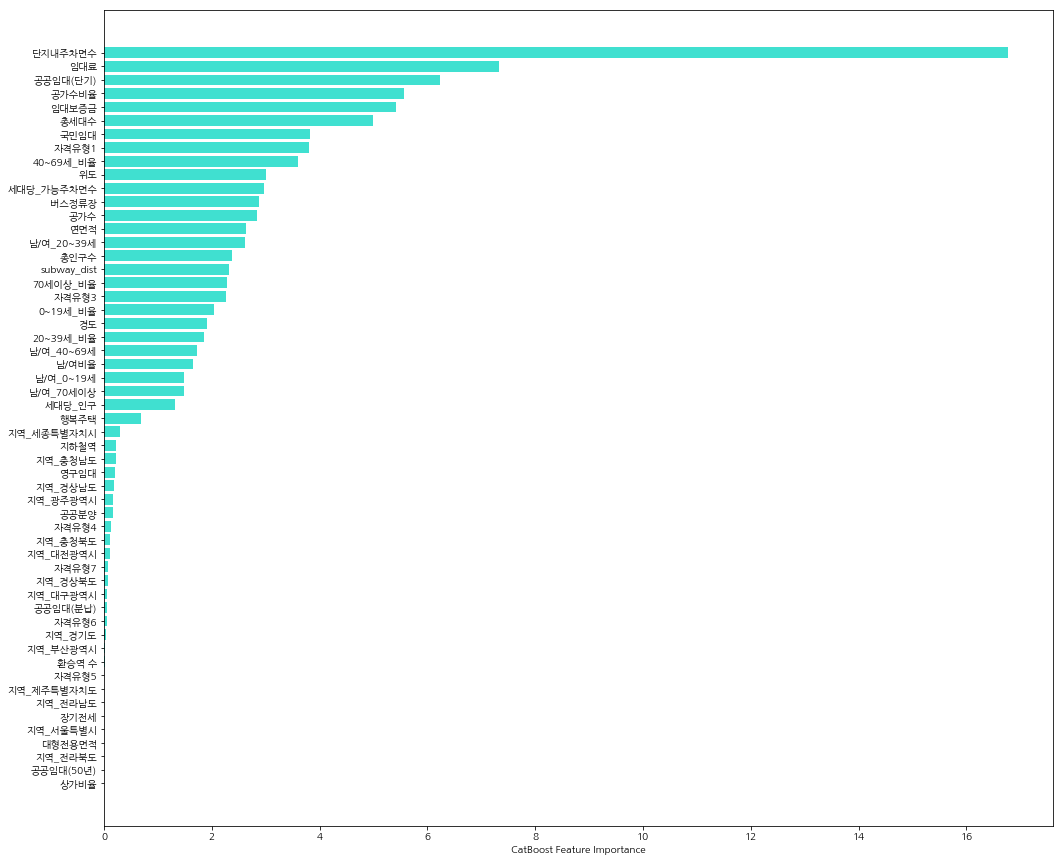

In [153]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model2.feature_importances_.argsort()
plt.barh(X.test.columns[sorted_feature_importance], 
        model2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [193]:
one=pd.read_csv("0713_cb.csv")
one = one.loc[~one.code.isin(['C2335', 'C1327', 'C2675'])]
test_= test_split.loc[~test_split.code.isin(['C2335', 'C1327', 'C2675'])]
mean_absolute_error(one.num, test_.num)

38.90434391646287

In [194]:
test_split.to_csv('0716_2.csv', index=False)